In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
# Cargar datos desde un archivo CSV
matches = pd.read_csv('/content/drive/MyDrive/matches.csv', sep=',')

In [109]:
matches.head()

,Unnamed: 0,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,...,Match Report,Notes,Sh,SoT,Dist,FK,PK,PKatt,Season,Team
0,1,2023-08-12,12:30,Premier League,Matchweek 1,Sat,Home,W,2.0,1.0,...,Match Report,NaN,15.0,7.0,19.1,0.0,0,0,2024,Arsenal
1,2,2023-08-21,20:00,Premier League,Matchweek 2,Mon,Away,W,1.0,0.0,...,Match Report,NaN,13.0,2.0,16.4,0.0,1,1,2024,Arsenal
2,3,2023-08-26,15:00,Premier League,Matchweek 3,Sat,Home,D,2.0,2.0,...,Match Report,NaN,18.0,9.0,13.8,0.0,1,1,2024,Arsenal
3,4,2023-09-03,16:30,Premier League,Matchweek 4,Sun,Home,W,3.0,1.0,...,Match Report,NaN,17.0,5.0,15.0,0.0,0,0,2024,Arsenal
4,5,2023-09-17,16:30,Premier League,Matchweek 5,Sun,Away,W,1.0,0.0,...,Match Report,NaN,13.0,4.0,17.4,0.0,0,0,2024,Arsenal


In [110]:
# visualizar partidos jugados por equipos en todas las competiciones 2023/2024
matches["Team"].value_counts()

Team
Arsenal                     74
West Ham United             74
Nottingham Forest           74
Brentford                   74
Everton                     74
Crystal Palace              74
Fulham                      74
Bournemouth                 74
Wolverhampton Wanderers     74
Aston Villa                 74
Liverpool                   74
Manchester United           73
Brighton and Hove Albion    73
Manchester City             73
Chelsea                     73
Newcastle United            73
Tottenham Hotspur           73
Leicester City              38
Leeds United                38
Southampton                 38
Luton Town                  36
Burnley                     36
Sheffield United            36
Name: count, dtype: int64

In [111]:
# visualizar cantidad de fechas de juego
matches["Round"].value_counts()

Round
Matchweek 1     40
Matchweek 19    40
Matchweek 21    40
Matchweek 22    40
Matchweek 23    40
Matchweek 24    40
Matchweek 25    40
Matchweek 26    40
Matchweek 27    40
Matchweek 28    40
Matchweek 30    40
Matchweek 31    40
Matchweek 32    40
Matchweek 33    40
Matchweek 29    40
Matchweek 35    40
Matchweek 36    40
Matchweek 2     40
Matchweek 20    40
Matchweek 18    40
Matchweek 17    40
Matchweek 3     40
Matchweek 4     40
Matchweek 5     40
Matchweek 6     40
Matchweek 7     40
Matchweek 8     40
Matchweek 9     40
Matchweek 10    40
Matchweek 11    40
Matchweek 12    40
Matchweek 13    40
Matchweek 14    40
Matchweek 15    40
Matchweek 16    40
Matchweek 34    34
Matchweek 37    20
Matchweek 38    20
Name: count, dtype: int64

In [112]:
matches.dtypes  # Observar tipos de datos para convertir algunos datos categóricos a numéricos

Unnamed: 0        int64
Date             object
Time             object
Comp             object
Round            object
Day              object
Venue            object
Result           object
GF              float64
GA              float64
Opponent         object
xG              float64
xGA             float64
Poss            float64
Attendance      float64
Captain          object
Formation        object
Referee          object
Match Report     object
Notes           float64
Sh              float64
SoT             float64
Dist            float64
FK              float64
PK                int64
PKatt             int64
Season            int64
Team             object
dtype: object

In [113]:
# Limpieza y Preprocesamiento de Datos
matches["Date"] = pd.to_datetime(matches["Date"])# Convertir la columna 'Date' a tipo fecha y hora, y
matches["Venue_code"] = matches["Venue"].astype("category").cat.codes #'Venue' a datos númericos /'.cat.codes' convierte las categorías en códigos numéricos.
# Codificar columnas categóricas
matches["Opp_code"] = matches["Opponent"].astype("category").cat.codes
matches["Day_code"] = matches["Date"].dt.dayofweek
matches["Hour"] = matches["Time"].str.replace(":.+", "", regex=True).astype("int")
matches["Target"] = (matches["Result"] == "W").astype("int") #Codificación de resultados de partidos en una variable binaria

# Eliminación de columnas innecesarias
matches = matches.drop(columns=["Comp", "Notes"])

In [114]:
matches.head()

,Unnamed: 0,Date,Time,Round,Day,Venue,Result,GF,GA,Opponent,...,FK,PK,PKatt,Season,Team,Venue_code,Opp_code,Day_code,Hour,Target
0,1,2023-08-12,12:30,Matchweek 1,Sat,Home,W,2.0,1.0,Nott'ham Forest,...,0.0,0,0,2024,Arsenal,1,17,5,12,1
1,2,2023-08-21,20:00,Matchweek 2,Mon,Away,W,1.0,0.0,Crystal Palace,...,0.0,1,1,2024,Arsenal,0,7,0,20,1
2,3,2023-08-26,15:00,Matchweek 3,Sat,Home,D,2.0,2.0,Fulham,...,0.0,1,1,2024,Arsenal,1,9,5,15,0
3,4,2023-09-03,16:30,Matchweek 4,Sun,Home,W,3.0,1.0,Manchester Utd,...,0.0,0,0,2024,Arsenal,1,15,6,16,1
4,5,2023-09-17,16:30,Matchweek 5,Sun,Away,W,1.0,0.0,Everton,...,0.0,0,0,2024,Arsenal,0,8,6,16,1


In [115]:
matches.shape

(1474, 31)

**Division de los datos y creacion del modelo**

Inicializaremos el modelo con algunos parametros:
- **n_estimators** : número de arboles de decisión individuales que queremos que entrene /entre mas alto este valor mas tardara el algoritmo para ejecutar pero mejor sera, mas preciso.
- **min_simples_split**: división minima de muestras que queremos tener en una hoja del arbold e decisión anets de dividir el nodo, cuanto mayor sea es menos probable que haya sobreajuste, pero menor sera su precision en los datos de train.
- **random_state** = parametros aleatorios del bosque

In [165]:
# Importación de RandomForestClassifier desde scikit-learn
from sklearn.ensemble import RandomForestClassifier

# Configurar y entrenar el modelo RandomForest
rf = RandomForestClassifier(n_estimators=45, min_samples_split=10, random_state=42)
train = matches[matches["Date"] < '2024-01-01']
test = matches[matches["Date"] > '2024-01-01']
predictors = ["Venue_code", "Opp_code", "Hour", "Day_code"]
rf.fit(train[predictors], train["Target"])

# Realizar predicciones y evaluar el modelo
preds = rf.predict(test[predictors])

In [166]:
precision = accuracy_score(test["Target"], preds)
print("La precisión general del modelo es de :", precision)

La precisión general del modelo es de : 0.634375


Este valor indica la proporción de veces que el modelo predijo correctamente una victoria comparado con el número total de veces que predijo que un equipo ganaría.

In [167]:
#crear un nuevo DataFrame llamado combined que contiene dos columnas: actual y predicted.
combined = pd.DataFrame(dict(actual=test["Target"], predicted=preds))

#TABLA CRUZADA
print("la tabla cruzada es la siguinte:")
pd.crosstab(index=combined["actual"], columns=combined["predicted"])

la tabla cruzada es la siguinte:


predicted,0,1
actual,,
0,148,56
1,61,55


Se puede ver que cuando se predijo una perdida o un empate la mayotia de veces se acerto 145 veces, 59 veces se fallo. Pero cuando la predicción fue una victoria nos equivocamos mas a menudo (62) de las que acertamos (54).
COMO ESTE MODELO ES PARA PREDECIR VICTORIAS necesitamos revisar un poco nuestra metrica de precision.

In [168]:
win_precision = precision_score(test["Target"], preds) # Calcular el porcentaje de aciertos del modelo al predecir victorias
print("la precisión para predecir victorias es de:", win_precision)

la precisión para predecir victorias es de: 0.4954954954954955


**Mejorar la precisión**

- *Aumentar caracteristicas predictoras*

Dividiremos el cuadro de datos de nuestros partidos por equipo ya que queremos calcular promedios moviles para el rendimiento del equipo (ultimos juegos, tiros al arco, goles en contra, etc)

calcularemos promedios móviles (rolling averages) de ciertas características estadísticas para cada equipo en el conjunto de datos de partidos. Esto se hace para generar nuevas características que pueden mejorar la precisión de el modelo ya entrenado.

In [169]:
# Crear promedios móviles
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("Date")
    rolling_stats = group[cols].rolling(3, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

Calcular promedios móviles para varias estadísticas por equipo, agregar esas estadísticas al DataFrame, ajustar el índice para eliminar la jerarquía creada por la agrupación, y luego restablece el índice a una secuencia numérica continua.

In [170]:
cols = ["GF", "GA", "Sh", "SoT", "Dist", "FK", "PK", "PKatt"]
new_cols = [f"{c}_rolling" for c in cols] #Utiliza una comprensión de listas para iterar sobre cols y añade el sufijo _rolling a cada nombre de columna.
all_predictors = predictors + new_cols
matches_rolling = matches.groupby("Team").apply(lambda x: rolling_averages(x, cols, new_cols))
matches_rolling = matches_rolling.droplevel('Team')
matches_rolling.index = range(matches_rolling.shape[0])

**Reentrenamiento del modelo de aprendizaje automático**

In [171]:
# Función diseñada para entrenar un modelo de Random Forest, realizar predicciones y evaluar la precisión de las predicciones para un conjunto de datos específico.
def make_predictions(data, predictors):
    train = data[data["Date"] < '2024-01-01']
    test = data[data["Date"] > '2024-01-01']
    rf.fit(train[predictors], train["Target"])
    preds = rf.predict(test[predictors])
    combined = pd.DataFrame(dict(actual=test["Target"], predicted=preds), index=test.index)
    Win_precision = precision_score(test["Target"], preds)
    return combined, Win_precision, test, rf.predict_proba(test[predictors])[:, 1]

In [172]:
# Ejecutar predicciones con nuevos predictores y visualizar resultados
combined, Win_precision, test, rf_probs = make_predictions(matches_rolling, predictors + new_cols)
print("la tabla cruzada con nuevas caracteristicas es la siguinte")
pd.crosstab(index=combined["actual"], columns=combined["predicted"])

la tabla cruzada con nuevas caracteristicas es la siguinte


predicted,0,1
actual,,
0,155,49
1,57,59


Se puede apreciar en la tabla cruzada una leve mejora en la predicción de las victorias, donde  el modelo predijo que habria victoria y en realidad hubo victoria unas 59 veces; en comparación cuando se equivoco e indico que no habria victoria y si hubo victoria (57 veces).

In [173]:
combined, Win_precision, test, rf_probs = make_predictions(matches_rolling, predictors + new_cols)
print("la precisión para predecir victorias con nuevas caracteristicas es de:", Win_precision)


la precisión para predecir victorias con nuevas caracteristicas es de: 0.5462962962962963


In [125]:
#se visualiza cierta mejora, podemos ver donde estaban nuestras predicciones erroneas
combined

,actual,predicted
55,1,1
56,1,1
57,1,1
58,1,1
59,1,0
...,...,...
1400,0,0
1401,0,0
1402,0,0
1403,1,0


In [126]:
#como en la tabla anterior no podemos ver los equipos para saber cuales estamos prediciendo mal
combined = combined.merge(matches_rolling[["Date", "Team", "Opponent", "Result"]], left_index=True, right_index=True)
combined.head(5)

,actual,predicted,Date,Team,Opponent,Result
55,1,1,2024-01-20,Arsenal,Crystal Palace,W
56,1,1,2024-01-30,Arsenal,Nott'ham Forest,W
57,1,1,2024-02-04,Arsenal,Liverpool,W
58,1,1,2024-02-11,Arsenal,West Ham,W
59,1,0,2024-02-17,Arsenal,Burnley,W


**Combinación de pronostico como local y visitante**

In [127]:
#normalizar los nombres para que sean iguales en Team y en Opponent para algunos equipos /creamos diccionario
class MissingDict(dict):
    __missing__ = lambda self, key: key

map_values = {"Brighton and Hove Albion": "Brighton", "Manchester United": "Manchester Utd", "Newcastle United": "Newcastle Utd", "Tottenham Hotspur": "Tottenham", "West Ham United": "West Ham", "Wolverhampton Wanderers": "Wolves"}
mapping = MissingDict(**map_values)

In [128]:
combined["new_team"] = combined["Team"].map(mapping)

#FUSIONAR el marco de datos consigo mismo
merged = combined.merge(combined, left_on=["Date", "new_team"], right_on=["Date", "Opponent"])
print("la tabla con las predicciones tanto para el equipo local(x) como visitante(y) es la siguiente:")
merged

la tabla con las predicciones tanto para el equipo local(x) como visitante(y) es la siguiente:


,actual_x,predicted_x,Date,Team_x,Opponent_x,Result_x,new_team_x,actual_y,predicted_y,Team_y,Opponent_y,Result_y,new_team_y
0,1,1,2024-01-20,Arsenal,Crystal Palace,W,Arsenal,0,0,Crystal Palace,Arsenal,L,Crystal Palace
1,1,1,2024-01-30,Arsenal,Nott'ham Forest,W,Arsenal,0,0,Nottingham Forest,Arsenal,L,Nottingham Forest
2,1,1,2024-02-04,Arsenal,Liverpool,W,Arsenal,0,0,Liverpool,Arsenal,L,Liverpool
3,1,1,2024-02-11,Arsenal,West Ham,W,Arsenal,0,0,West Ham United,Arsenal,L,West Ham
4,1,0,2024-02-17,Arsenal,Burnley,W,Arsenal,0,0,Burnley,Arsenal,L,Burnley
...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,0,0,2024-04-13,Wolverhampton Wanderers,Nott'ham Forest,D,Wolves,0,0,Nottingham Forest,Wolves,D,Nottingham Forest
284,0,0,2024-04-20,Wolverhampton Wanderers,Arsenal,L,Wolves,1,0,Arsenal,Wolves,W,Arsenal
285,0,0,2024-04-24,Wolverhampton Wanderers,Bournemouth,L,Wolves,1,0,Bournemouth,Wolves,W,Bournemouth
286,1,0,2024-04-27,Wolverhampton Wanderers,Luton Town,W,Wolves,0,0,Luton Town,Wolves,L,Luton Town


In [129]:
#Cuando el modelo predijo que el equipo ganaria y el oponente perderia y lo que real/ sucedio
merged[(merged["predicted_x"] == 1) & (merged["predicted_y"] ==0)]["actual_x"].value_counts()

actual_x
1    48
0    26
Name: count, dtype: int64

**Modelo redes neuronales profundas**

In [130]:
# Preprocesamiento de Datos
X = matches_rolling[predictors + new_cols].values
y = matches_rolling["Target"].values

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Definir el modelo de red neuronal
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Evaluar el modelo
y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracyRN = accuracy_score(y_test, y_pred)
precisionRN = precision_score(y_test, y_pred)


Epoch 1/50
29/29 [==============================] - 2s 27ms/step - loss: 0.7477 - accuracy: 0.5006 - precision: 0.4000 - val_loss: 0.6746 - val_accuracy: 0.5867 - val_precision: 0.5625
Epoch 2/50
29/29 [==============================] - 0s 7ms/step - loss: 0.6879 - accuracy: 0.5873 - precision: 0.4480 - val_loss: 0.6759 - val_accuracy: 0.5733 - val_precision: 0.5556
Epoch 3/50
29/29 [==============================] - 0s 8ms/step - loss: 0.6659 - accuracy: 0.6073 - precision: 0.4724 - val_loss: 0.6785 - val_accuracy: 0.5733 - val_precision: 0.6000
Epoch 4/50
29/29 [==============================] - 0s 8ms/step - loss: 0.6646 - accuracy: 0.6174 - precision: 0.4951 - val_loss: 0.6729 - val_accuracy: 0.5644 - val_precision: 0.4545
Epoch 5/50
29/29 [==============================] - 0s 9ms/step - loss: 0.6614 - accuracy: 0.6240 - precision: 0.5097 - val_loss: 0.6711 - val_accuracy: 0.5600 - val_precision: 0.4167
Epoch 6/50
29/29 [==============================] - 0s 8ms/step - loss: 0.6621 

In [131]:
print(f"La precisión general del modelo es de: {accuracyRN}")
print(f"la precisión para predecir victorias es de: {precisionRN}")

La precisión general del modelo es de: 0.6476868327402135
la precisión para predecir victorias es de: 0.6222222222222222


**Comparación de los dos modelos**

En cuanto a la precisión general y la precisión de victorias.

In [132]:
print(f"Random Forest - Precisión general del modelo: {precision}, Precisión de victorias: {Win_precision}")
print(f"Neural Network - Precisión general del modelo: {accuracyRN}, Precisión de victorias: {precisionRN}")


Random Forest - Precisión general del modelo: 0.621875, Precisión de victorias: 0.5566037735849056
Neural Network - Precisión general del modelo: 0.6476868327402135, Precisión de victorias: 0.6222222222222222


In [133]:
# Obtener la matriz de confusión
from sklearn.metrics import confusion_matrix
# Obtener la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Negativo', 'Actual Positivo'], columns=['Predicho Negativo', 'Predicho Positivo'])

print("Matriz de confusión:")
print(conf_matrix_df)

Matriz de confusión:
                 Predicho Negativo  Predicho Positivo
Actual Negativo                154                 17
Actual Positivo                 82                 28


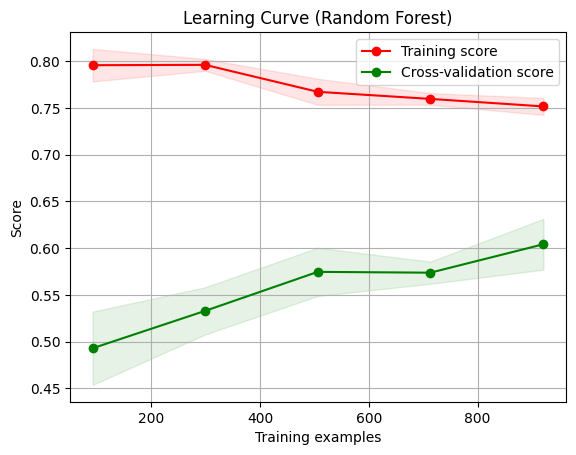

In [174]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, confusion_matrix, classification_report

# Asegúrate de tener todos los imports necesarios para el código previo también.
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Generar curva de aprendizaje para el modelo Random Forest
plot_learning_curve(rf, "Learning Curve (Random Forest)", train[predictors], train["Target"], cv=5)
plt.show()


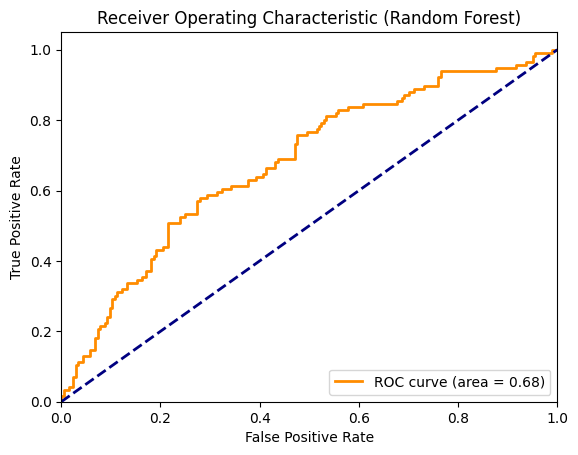

In [175]:
# Calcular la curva ROC y el AUC
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(test["Target"], rf_probs)
roc_auc = roc_auc_score(test["Target"], rf_probs)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Random Forest)')
plt.legend(loc="lower right")
plt.show()

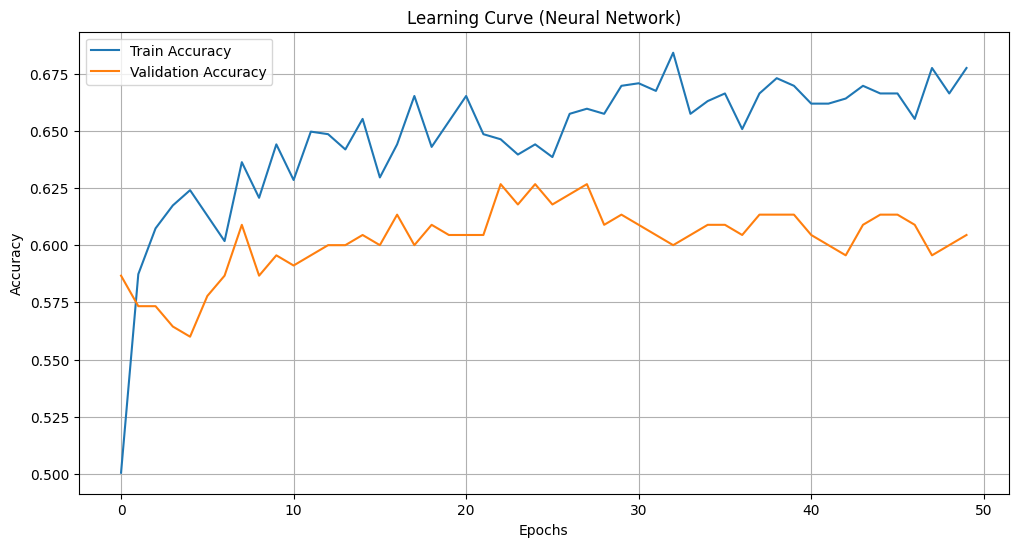

9/9 [==============================] - 0s 5ms/step


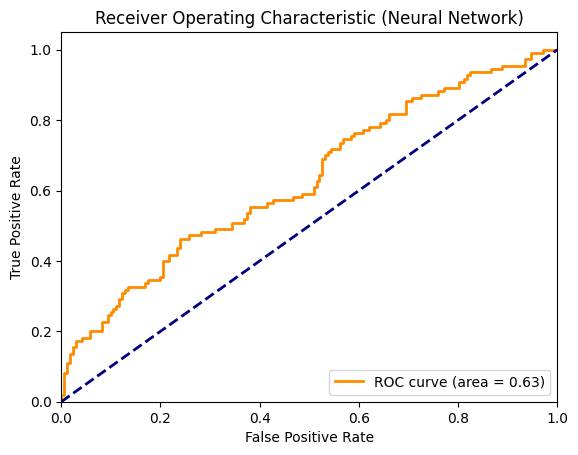

In [136]:
# Curva de aprendizaje para red neuronal
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Learning Curve (Neural Network)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Curva ROC y AUC para red neuronal
y_pred_probs = model.predict(X_test).ravel()

fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = roc_auc_score(y_test, y_pred_probs)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Neural Network)')
plt.legend(loc="lower right")
plt.show()


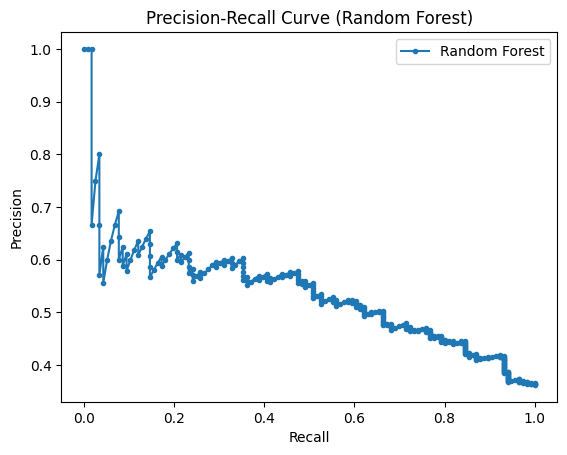

In [138]:
precision, recall, _ = precision_recall_curve(test["Target"], rf_probs)
plt.figure()
plt.plot(recall, precision, marker='.', label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Random Forest)')
plt.legend()
plt.show()


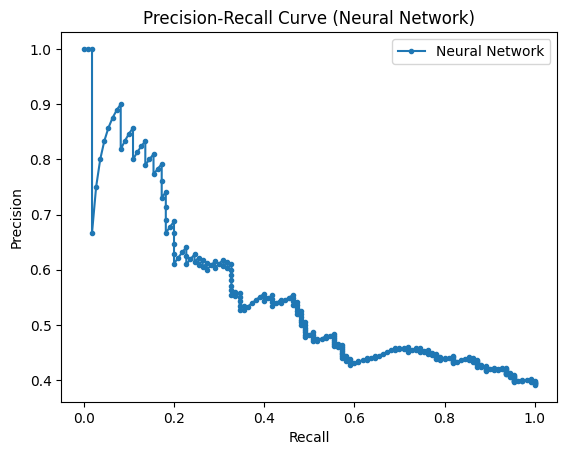

In [140]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
plt.figure()
plt.plot(recall, precision, marker='.', label='Neural Network')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Neural Network)')
plt.legend()
plt.show()
